## Pairs Trading 

Pairs trading is a market-neutral trading strategy that involves identifying two historically correlated securities and taking opposing positions in them. The basic idea is to exploit the temporary divergence in the prices of the two securities, with the expectation that they will eventually revert to their historical relationship.

Key Concepts:

1. Correlation: Pairs trading relies on finding two securities that have a high historical correlation. These could be stocks within the same industry, ETFs tracking similar indices, or commodities with a known relationship.
2. Long and Short Positions: When the price of one security in the pair deviates significantly from its historical relationship with the other, the trader goes long (buys) the underperforming security and short (sells) the outperforming one.
3. Mean Reversion: The strategy is based on the assumption that the prices of the two securities will revert to their historical mean. This means that the temporary divergence in prices will correct itself, allowing the trader to profit from the convergence.
4. Market Neutrality: Pairs trading aims to be market-neutral, meaning that the overall portfolio is less affected by broad market movements. This is achieved by holding both long and short positions.

### Import Libraries

In [15]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Download Data

In [16]:
start = "2018-01-01"
end = "2023-01-01"
stock1_name = "AAPL"
stock2_name = "MSFT"

stock1 = yf.Ticker(stock1_name)
stock1_data = stock1.history(interval='1d', start=start, end=end)
stock2 = yf.Ticker(stock2_name)
stock2_data = stock2.history(interval='1d', start=start, end=end)

### Adjust Time Series

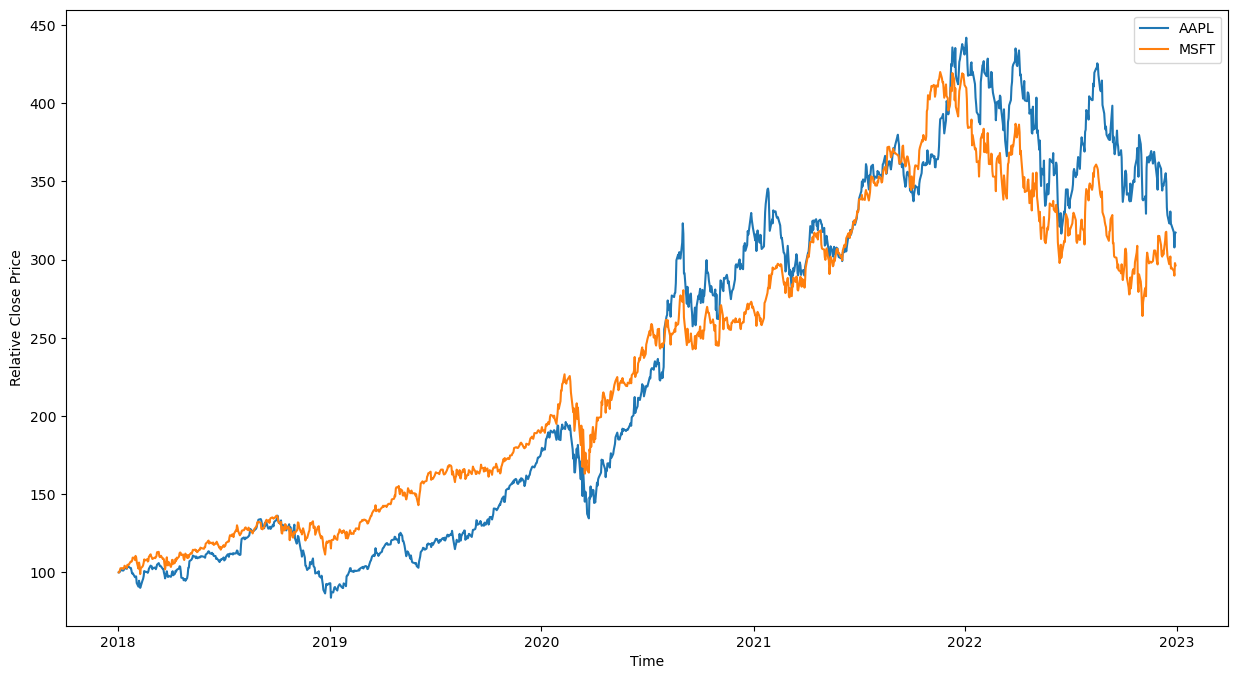

In [17]:
stock1_close_relative = stock1_data["Close"]/stock1_data["Close"][0] * 100
stock2_close_relative = stock2_data["Close"]/stock2_data["Close"][0] * 100
plt.figure(figsize=(15, 8))
plt.plot(stock1_close_relative, label='AAPL')
plt.plot(stock2_close_relative, label='MSFT')
plt.xlabel('Time')
plt.ylabel('Relative Close Price')
plt.legend()
plt.show()

### Regression Model

In [18]:
Y = np.log(stock2_data["Close"])
X = np.log(stock1_data["Close"])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
alpha = results.params.values[0]
beta = results.params.values[1]
errors = Y - (alpha + X["Close"] * beta)

### Spread

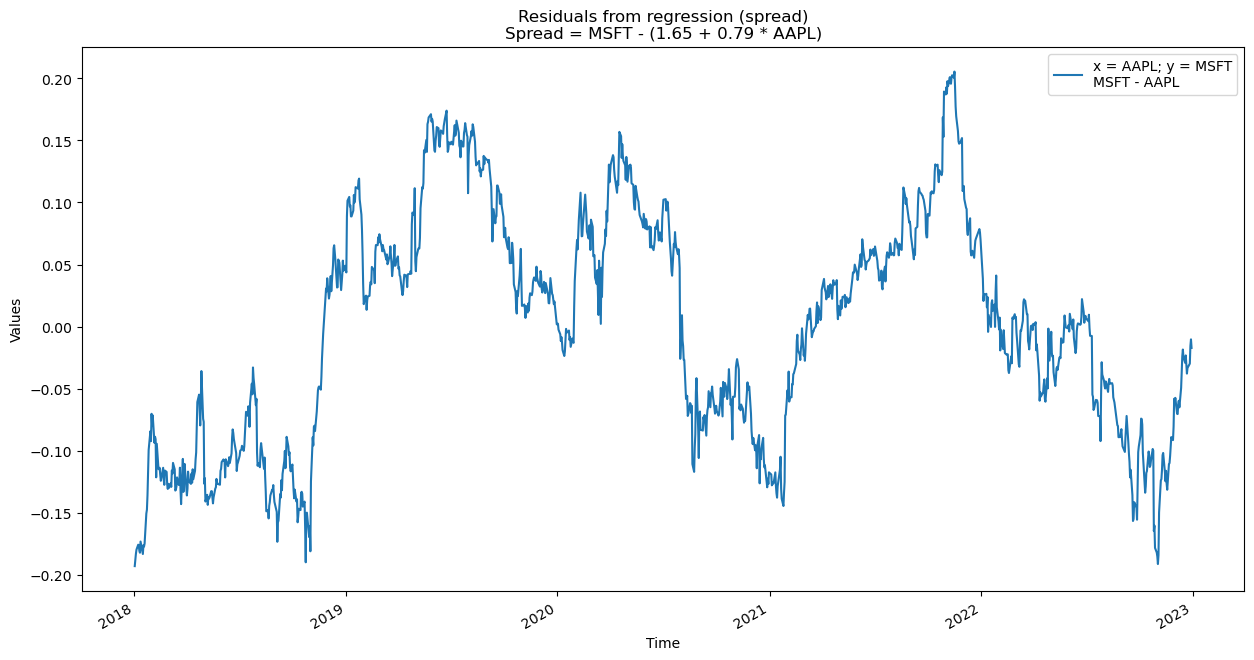

In [19]:
plt.figure(figsize=(15, 8))
errors.plot(label=f"x = {stock1_name}; y = {stock2_name}\n{stock2_name} - {stock1_name}")
plt.title(f"Residuals from regression (spread)\nSpread = {stock2_name} - ({alpha:.2f} + {beta:.2f} * {stock1_name})")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

### Dickey Fuller Test

In [20]:
dftest = adfuller(errors, maxlag=1)
dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())
print(f"Dickey Fuller Result:\n{dfoutput}\n\nDickey Fuller Critical Values:\n{critical_values}")

Dickey Fuller Result:
Test Statistic                   -2.712452
p-value                           0.071908
#Lags Used                        1.000000
Number of Observations Used    1257.000000
dtype: float64

Dickey Fuller Critical Values:
1%    -3.435563
5%    -2.863842
10%   -2.567996
dtype: float64


### Z-score

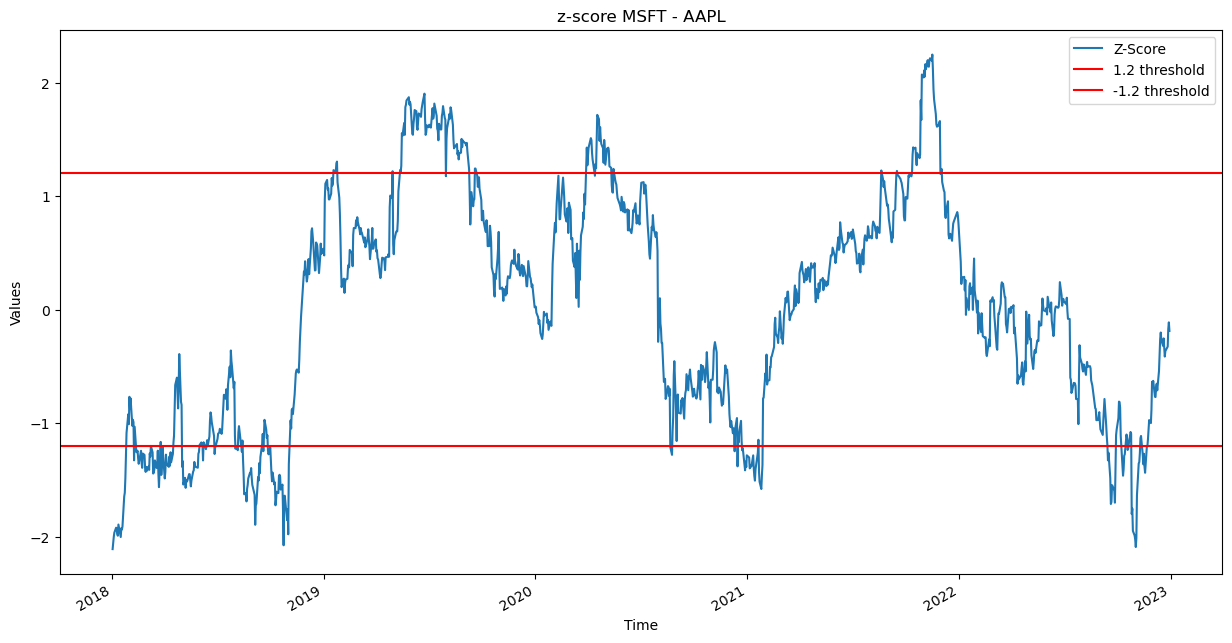

In [22]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)

plt.figure(figsize=(15, 8))
zscore.plot(label="Z-Score")
plt.title(f"z-score {stock2_name} - {stock1_name}")
plt.xlabel("Time")
plt.ylabel("Values")
plt.axhline(y=1.2, color='r', label='1.2 threshold')
plt.axhline(y=-1.2, color='r', label='-1.2 threshold')
plt.legend()
plt.show()

### Long Short Strategy

In [23]:
btest = pd.DataFrame()
btest["stock2"] = stock2_data["Close"]
btest["stock1"] = stock1_data["Close"]

btest["short signal"] = (zscore > 1.2) & (zscore.shift(1) < 1.2)
btest["short exit"] = (zscore < -1.2) & (zscore.shift(1) > -1.2)

btest["long signal"] = (zscore < -1.2) & (zscore.shift(1) > -1.2)
btest["long exit"] = (zscore > 1.2) & (zscore.shift(1) < 1.2)

### Backtest

In [24]:
spread_side = None
counter = -1
backtest_result = []
indicator = 0

for time, signals_stock in btest.iterrows():
    counter += 1
    stock2_, stock1_, short_signal, short_exit, long_signal, long_exit = signals_stock

    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time, return_stock2, return_stock1, spread_side])

    if short_signal == True:
        spread_side = "short"
    elif long_signal == True:
        spread_side = "long"

    elif spread_side == "long":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1
        backtest_result.append([time, return_stock2, -return_stock1, spread_side])

        if long_exit == True:
            spread_side = None

    elif spread_side == "short":
        return_stock2 = btest["stock2"][counter] / btest["stock2"][counter - 1] - 1
        return_stock1 = btest["stock1"][counter] / btest["stock1"][counter - 1] - 1
        backtest_result.append([time, -return_stock2, return_stock1, spread_side])

        if short_exit == True:
            spread_side = None

# Transform into DataFrame
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ["Date", "stock2", "stock1", "Side"]
backtest_pandas["Stock2 P&L"] = np.cumprod(backtest_pandas["stock2"] + 1.)
backtest_pandas["Stock1 P&L"] = np.cumprod(backtest_pandas["stock1"] + 1.)
backtest_pandas["Total P&L"] = backtest_pandas["Stock1 P&L"] + backtest_pandas["Stock2 P&L"]
backtest_pandas.index = backtest_pandas["Date"]

### Performance

In [25]:
# Compute Sharpe Ratio
daily_returns = backtest_pandas["Total P&L"].pct_change().dropna()
sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.9797374021059875


In [26]:
# Compute Max Drawdown
cumulative_returns = backtest_pandas["Total P&L"]
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown}")

Max Drawdown: -0.19106267919824793


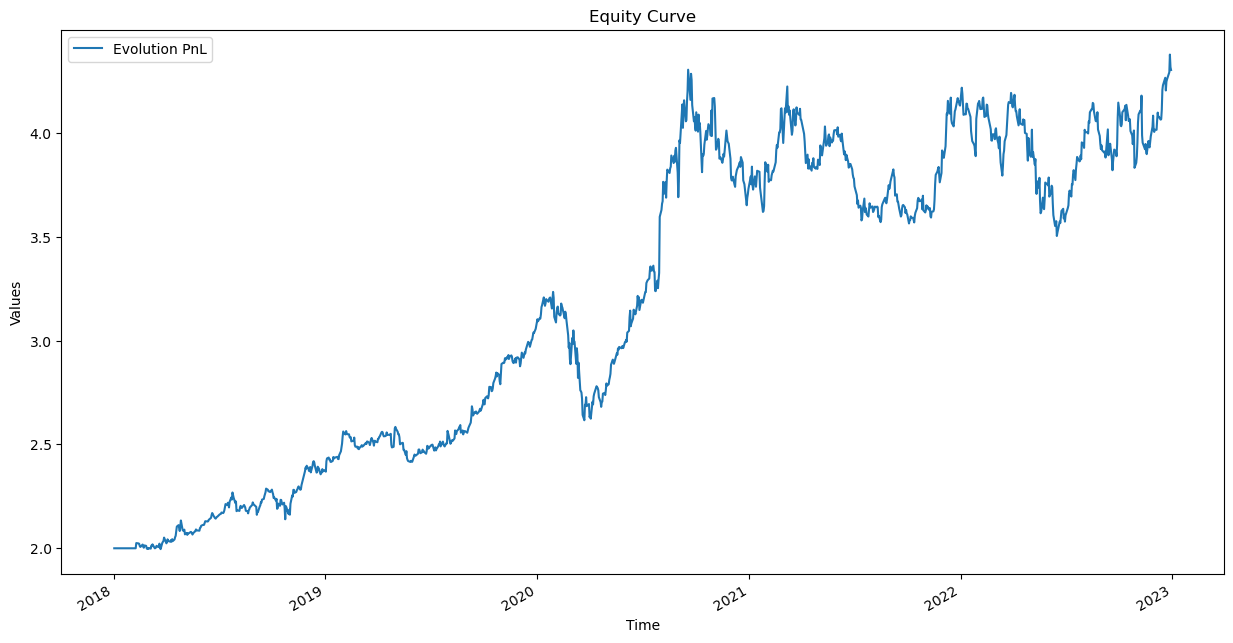

In [33]:
plt.figure(figsize=(15,8))
backtest_pandas['Total P&L'].plot(label='Evolution PnL')
plt.title("Equity Curve")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()